In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -o housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1390k  100 1390k    0     0  2   0      0 --:--:-- --:--:-- --:--:--     0860k      0 --:--:-- --:--:-- --:--:-- 2860k


In [27]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [28]:
selected_cols = ['latitude',
                 'longitude',
                 'housing_median_age',
                 'total_rooms',
                 'total_bedrooms',
                 'population',
                 'households',
                 'median_income',
                 'median_house_value',
                 'ocean_proximity'
                ]
columns_with_na = df.columns[df.isnull().sum()>0].values
print(columns_with_na)
for col in columns_with_na:
    df[col] = df[col].fillna(0)

['total_bedrooms']


In [29]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [30]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [31]:
y = df.pop('median_house_value')

In [32]:
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size=0.25, random_state=1)

In [35]:
dv = DictVectorizer(sparse=False)
dict_train = df_train.to_dict(orient="records")
dv.fit(dict_train)
X_train = dv.transform(dict_train)
dict_val = df_val.to_dict(orient="records")
X_val = dv.transform(dict_val)

In [51]:
'''
Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

    Train a model with max_depth=1.

Which feature is used for splitting the data?

    ocean_proximity=INLAND
    total_rooms
    latitude
    population
'''
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)
tree_text = export_text(model, feature_names=dv.get_feature_names())
print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/opt/anaconda3/envs/mlzoomcamp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
'''
Question 2

Train a random forest model with these parameters:

    n_estimators=10
    random_state=1
    n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

    0.05
    0.25
    0.55
    0.85
'''
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
print(mean_squared_error(y_val_pred, y_val))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print(round(rmse(y_val_pred, y_val.values),2))

0.060413676586540316
0.25


([<matplotlib.axis.XTick at 0x7fbd4c0140a0>,
 [Text(0, 0, '10'),
  Text(1, 0, '20'),
  Text(2, 0, '30'),
  Text(3, 0, '40'),
  Text(4, 0, '50'),
  Text(5, 0, '60'),
  Text(6, 0, '70'),
  Text(7, 0, '80'),
  Text(8, 0, '90'),
  Text(9, 0, '100'),
  Text(10, 0, '110'),
  Text(11, 0, '120'),
  Text(12, 0, '130'),
  Text(13, 0, '140'),
  Text(14, 0, '150'),
  Text(15, 0, '160'),
  Text(16, 0, '170'),
  Text(17, 0, '180'),
  Text(18, 0, '190'),
  Text(19, 0, '200')])

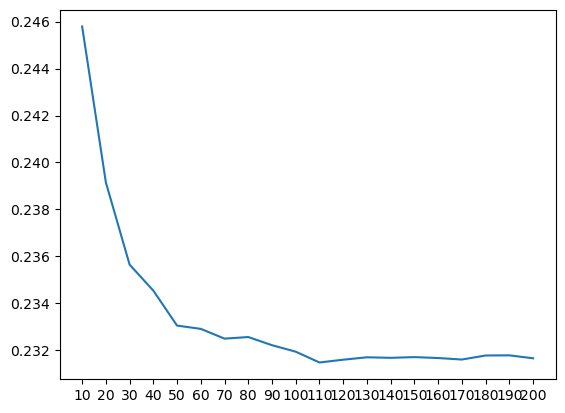

In [63]:
'''
Question 3

Now let's experiment with the n_estimators parameter

    Try different values of this parameter from 10 to 200 with step 10.
    Set random_state to 1.
    Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

    10
    50
    70
    150

'''

rmse_list = []
for n_est in range(10,210,10):
    model = RandomForestRegressor(n_estimators=n_est, n_jobs=-1, random_state=1)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    rmse_list.append(rmse(y_val_pred, y_val.values))

plt.plot(rmse_list)
plt.xticks(ticks=range(len(list(range(10,210,10)))),labels=range(10,210,10))
plt.show()

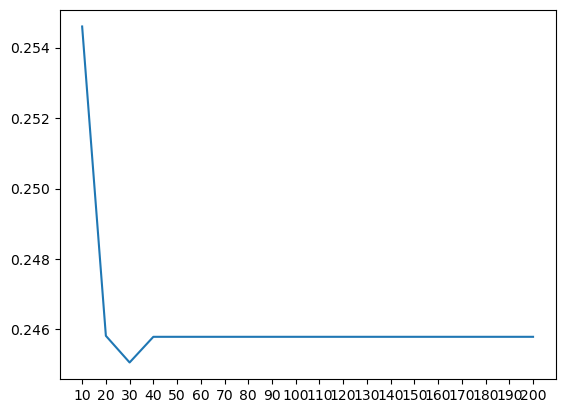

In [65]:
'''
Question 4

Let's select the best max_depth:

    Try different values of max_depth: [10, 15, 20, 25]
    For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
    Fix the random seed: random_state=1

What's the best max_depth:

    10
    15
    20
    25
'''
rmse_list = []
for max_d in range(10,210,10):
    model = RandomForestRegressor(n_estimators=10, max_depth=max_d, n_jobs=-1, random_state=1)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    rmse_list.append(rmse(y_val_pred, y_val.values))

plt.plot(rmse_list)
plt.xticks(ticks=range(len(list(range(10,210,10)))),labels=range(10,210,10))
plt.show()

In [75]:
'''Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

    Train the model with these parametes:
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1 (optional)
    Get the feature importance information from this model

What's the most important feature?

    total_rooms
    median_income
    total_bedrooms
    longitude
'''
model = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
model.fit(X_train, y_train)
#y_val_pred = model.predict(X_val)
importances = model.feature_importances_
#print(list(zip(dv.get_feature_names(), importances)))
df_importances = pd.DataFrame(list(zip(dv.get_feature_names(), importances)), columns=["feature", "importance"])
#df_importances.head()
df_importances.sort_values("importance", ascending=False)

/opt/anaconda3/envs/mlzoomcamp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197
10,population,0.030999
12,total_rooms,0.020465
11,total_bedrooms,0.019373
0,households,0.016141
9,ocean_proximity=NEAR OCEAN,0.004452


In [85]:
'''
Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

    Install XGBoost
    Create DMatrix for train and validation
    Create a watchlist
    Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

    0.3
    0.1
    Both gives same
'''

features = dv.get_feature_names()
features = [feat.replace('<','_') for feat in features]
print(features)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'dval')]
for eta_test in [0.3, 0.1]:
    xgb_params = {
        'eta': eta_test, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    print(f"ETA: {eta_test}")
    model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)
    print("===========")

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=_1H OCEAN', 'ocean_proximity=INLAND', 'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN', 'population', 'total_bedrooms', 'total_rooms']
ETA: 0.3
[0]	train-rmse:8.12733	dval-rmse:8.13245
[1]	train-rmse:5.69586	dval-rmse:5.70070
[2]	train-rmse:3.99540	dval-rmse:4.00041
[3]	train-rmse:2.80712	dval-rmse:2.81079
[4]	train-rmse:1.97834	dval-rmse:1.98175
[5]	train-rmse:1.40218	dval-rmse:1.40741
[6]	train-rmse:1.00099	dval-rmse:1.00700
[7]	train-rmse:0.72751	dval-rmse:0.73439
[8]	train-rmse:0.54190	dval-rmse:0.55047
[9]	train-rmse:0.42167	dval-rmse:0.43233
[10]	train-rmse:0.34481	dval-rmse:0.35782
[11]	train-rmse:0.29835	dval-rmse:0.31360
[12]	train-rmse:0.27095	dval-rmse:0.28865
[13]	train-rmse:0.25268	dval-rmse:0.27334
[14]	train-rmse:0.24295	dval-rmse:0.26605
[15]	train-rmse:0.23555	dval-rmse:0.26044
[16]	train-rmse:0.22630	dval-rmse:0.25229
[17]	train-rmse:0.2223

[89]	train-rmse:0.18855	dval-rmse:0.23220
[90]	train-rmse:0.18794	dval-rmse:0.23206
[91]	train-rmse:0.18728	dval-rmse:0.23167
[92]	train-rmse:0.18691	dval-rmse:0.23162
[93]	train-rmse:0.18620	dval-rmse:0.23117
[94]	train-rmse:0.18586	dval-rmse:0.23104
[95]	train-rmse:0.18541	dval-rmse:0.23106
[96]	train-rmse:0.18470	dval-rmse:0.23089
[97]	train-rmse:0.18405	dval-rmse:0.23067
[98]	train-rmse:0.18385	dval-rmse:0.23057
[99]	train-rmse:0.18329	dval-rmse:0.23054
